In [2]:
!pip install kaggle
!pip install tensorflow
!pip install opencv-python
!pip install keras

# Download the dataset from Kaggle (you'll need to have the Kaggle API configured)
!kaggle datasets download -d andrewmvd/helmet-detection -p /content/helmet_detection
# Unzip the downloaded dataset
!unzip -q /content/helmet_detection/helmet-detection.zip -d /content/helmet_detection

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 447, in run
    conflicts = self._determine_conflicts(to_install)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 578, in _determine_conflicts
    return check_install_conflicts(to_install)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/operations/check.py", line 101, in check_install_conflicts
    package_set, _ = create_package_set_from_installed()
              

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/helmet-detection
License(s): CC0-1.0
100% 390M/391M [00:20<00:00, 24.1MB/s]
100% 391M/391M [00:20<00:00, 19.8MB/s]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 179ms/step - accuracy: 0.1056 - loss: 454.3711 - val_accuracy: 1.0000 - val_loss: 1.0354
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.7795 - loss: 0.4963 - val_accuracy: 0.0000e+00 - val_loss: 6.3047e-05
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.0000e+00 - loss: 6.5154e-05 - val_accuracy: 0.0000e+00 - val_loss: 6.8330e-05
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.0000e+00 - loss: 6.8409e-05 - val_accuracy: 0.0000e+00 - val_loss: 6.8104e-05
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.0000e+00 - loss: 6.7840e-05 - val_accuracy: 0.0000e+00 - val_loss: 6.6931e-05
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.0000e+00 - loss: 6.6596e-05 - val_accuracy: 0.0000e+00 - val_loss: 6.5533e-05
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.0000e+00 - loss: 6.5167e-05 - val_accuracy: 0.0000e+00 - val_loss: 6.4026e-05
Epoch 8/10
20/20 ━━━

In [9]:
# Import necessary libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from lxml import etree


annotations_dir = "/content/helmet_detection/annotations"
images_dir = "/content/helmet_detection/images"

# Define classes
classes = ['With Helmet', 'Without Helmet']

# Parse XML annotations
def parse_annotation(annotation_file):
    tree = etree.parse(annotation_file)
    root = tree.getroot()
    objects = []
    for obj in root.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(bbox.find('xmin').text), int(bbox.find('ymin').text),
                              int(bbox.find('xmax').text), int(bbox.find('ymax').text)]
        objects.append(obj_struct)
    return objects

# Load images and annotations
def load_data(annotations_dir, images_dir):
    X, y = [], []
    for annotation_file in os.listdir(annotations_dir):
        if annotation_file.endswith('.xml'):
            annotation_path = os.path.join(annotations_dir, annotation_file)
            objects = parse_annotation(annotation_path)
            image_path = os.path.join(images_dir, annotation_file.replace('.xml', '.png'))
            image = load_img(image_path, target_size=(224, 224))
            image = img_to_array(image)
            X.append(preprocess_input(image))
            labels = [0] * len(classes)
            for obj in objects:
                label_idx = classes.index(obj['name'])
                labels[label_idx] = 1
            y.append(labels)
    return np.array(X), np.array(y)

# Load and preprocess data
X_train, y_train = load_data(annotations_dir, images_dir)

# Define Faster R-CNN model
def create_faster_rcnn():
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    output = layers.Dense(len(classes), activation='sigmoid')(x)
    model = models.Model(inputs=base_model.input, outputs=output)
    return model

# Compile model
model = create_faster_rcnn()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 778ms/step - accuracy: 0.5872 - loss: 0.9371 - val_accuracy: 0.7190 - val_loss: 0.5222
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.7941 - loss: 0.4669 - val_accuracy: 0.7647 - val_loss: 0.4838
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.7854 - loss: 0.4099 - val_accuracy: 0.7712 - val_loss: 0.4590
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8095 - loss: 0.3979 - val_accuracy: 0.7516 - val_loss: 0.4568
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8544 - loss: 0.3110 - val_accuracy: 0.7582 - val_loss: 0.4790
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8916 - loss: 0.2698 - val_accuracy: 0.7908 - val_loss: 0.4518
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9069 - loss: 0.2419 - val_accuracy: 0.8039 - val_loss: 0.4475
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9137 - loss: 0.1994 - val_accuracy: 0.7843 -

In [10]:
model.save("/content/helmet_detection_model.h5")

In [12]:
# Load the saved model
loaded_model = tf.keras.models.load_model("/content/helmet_detection_model.h5")

# Function to preprocess the input image
def preprocess_image(image_path):
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image

# Function to make predictions on images
def predict_image(image_path, model):
    preprocessed_image = preprocess_image(image_path)
    prediction = model.predict(preprocessed_image)
    return prediction

# Path to test images
test_images_dir = "/content/helmet_detection/images"

# Choose some images to test
image_filenames = [
    "BikesHelmets0.png",
    "BikesHelmets100.png",
    "BikesHelmets105.png",
    # Add more image filenames as needed
]

# Make predictions on test images
for image_filename in image_filenames:
    image_path = os.path.join(test_images_dir, image_filename)
    prediction = predict_image(image_path, loaded_model)
    print("Prediction for", image_filename, ":", prediction)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Prediction for BikesHelmets0.png : [[0.99415946 0.01206633]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Prediction for BikesHelmets100.png : [[0.9976671  0.00172809]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediction for BikesHelmets105.png : [[0.9653185  0.05026515]]


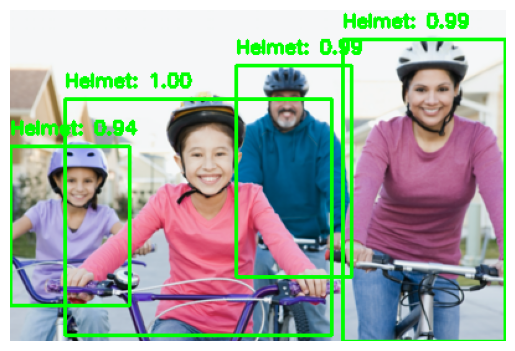

In [24]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Function to detect objects
def detect_objects(image_path, model):
    image = cv2.imread(image_path)

    if image is None:
        raise FileNotFoundError(f"Error: Could not load image at {image_path}. Check if the file exists!")

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_resized = cv2.resize(image_rgb, (640, 640))  # Resize to model's input size

    # Convert image to Tensor (⚠️ Convert to uint8 to match model's input)
    image_tensor = tf.convert_to_tensor(image_resized, dtype=tf.uint8)
    image_tensor = image_tensor[tf.newaxis, ...]  # Add batch dimension

    # Run inference
    detections = model(image_tensor)

    return image_rgb, detections

# Function to draw bounding boxes
def draw_bounding_boxes(image, detections, threshold=0.8):
    h, w, _ = image.shape
    boxes = detections['detection_boxes'][0].numpy()
    scores = detections['detection_scores'][0].numpy()
    classes = detections['detection_classes'][0].numpy().astype(int)

    for i in range(len(boxes)):
        if scores[i] > threshold:
            ymin, xmin, ymax, xmax = boxes[i]
            xmin, xmax, ymin, ymax = int(xmin * w), int(xmax * w), int(ymin * h), int(ymax * h)

            # Draw bounding box
            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

            # Put label
            label = f"Helmet: {scores[i]:.2f}"
            cv2.putText(image, label, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    return image

# Perform detection
image_path = "/content/helmet_detection/images/BikesHelmets0.png"
image, detections = detect_objects(image_path, detection_model)
image_with_boxes = draw_bounding_boxes(image, detections)

# Show result
plt.imshow(image_with_boxes)
plt.axis("off")
plt.show()


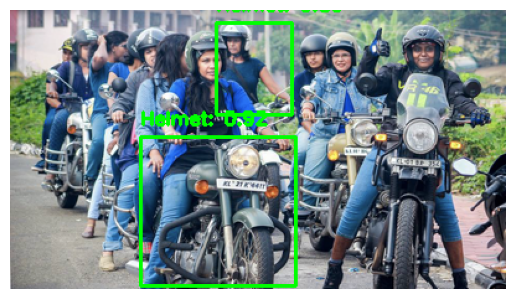

In [29]:


# Perform detection
image_path = "/content/helmet_detection/images/BikesHelmets6.png"
image, detections = detect_objects(image_path, detection_model)
image_with_boxes = draw_bounding_boxes(image, detections)

# Show result
plt.imshow(image_with_boxes)
plt.axis("off")
plt.show()
